# MUDE W3- Gradient Estimation 



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>

<b>Info:</b> 

This notebook is a very simple draft showing how we could use data from the ~~Nenana Ice Classic~~ (from any of the column in our dateset) for the numerical modelling part of MUDE.

The implementation is not particularly efficient, but it is quite flexible.


The dataset used is direclty loaded from github, so a a few extra packages are needed(`io` and  `requests`) but we could avoid using 'non-standard'libraries by downloading the file and loading it 'manually'.


</p>
</div>


In [4]:
from io import StringIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly 
import iceclassic as ice


# Loading the dataset

In [5]:

# we could load the data from the repo
file=ice.import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/main/book/data_files/time_serie_data.txt')
Data=pd.read_csv(file,skiprows=162,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
Data.info()

break_up_dates=Data.index[Data['Days until break up']==0]

print(str(break_up_dates[break_up_dates.year==2019]))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39309 entries, 1901-02-01 to 2024-02-06
Data columns (total 28 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Nenana: Rainfall [mm]                              29547 non-null  float64
 4   Nenana: Snowfall [mm]                              19945 non-null  float64
 5   Nenana: Snow depth [mm]                            15984 non-null  float64
 6   Nenana: Mean water temperature [C]                 2418 non-null   float64
 7   Nenana: Mean Discharge [m3/s]                      22562 non-null  float64
 8   Nenana: Air temperature [C]                        31171 non-null  fl

## Estimating gradients
the function below its included in the Pypi package, I'll leave the code here for a while to double check the implementation is correct and I'll remove it in a few days/week

def finite_differences(series:pd.Series):
    """
    Computes forward, central, and backward differences using the step size as days between measurement.
    
    Parameters
    ---------
    series: pd.Series
        Series with datetime index 
    
    Returns
    ---------
    df: pd.DataFrame
        DataFrame with forward, backward and central differences for the Series
    
    """
   
    days_forward = (series.index.to_series().shift(-1) - series.index.to_series()).dt.days
    days_backward = (series.index.to_series() - series.index.to_series().shift(1)).dt.days
    
    # Forward difference: (f(x+h) - f(x)) / h 
    forward = (series.shift(-1) - series) / days_forward

    # Backward difference: (f(x) - f(x-h)) / h,
    backward = (series - series.shift(1)) / days_backward

    # Central difference: (f(x+h) - f(x-h)) / (h_forward + h_backward)
    central = (series.shift(-1) - series.shift(1)) / (days_forward + days_backward) #
    
    # fixing start/end points
    forward.iloc[-1] = np.nan  
    backward.iloc[0] = np.nan  

    return pd.DataFrame({'forward': forward, 'backward': backward, 'central': central})


# Ice thickness

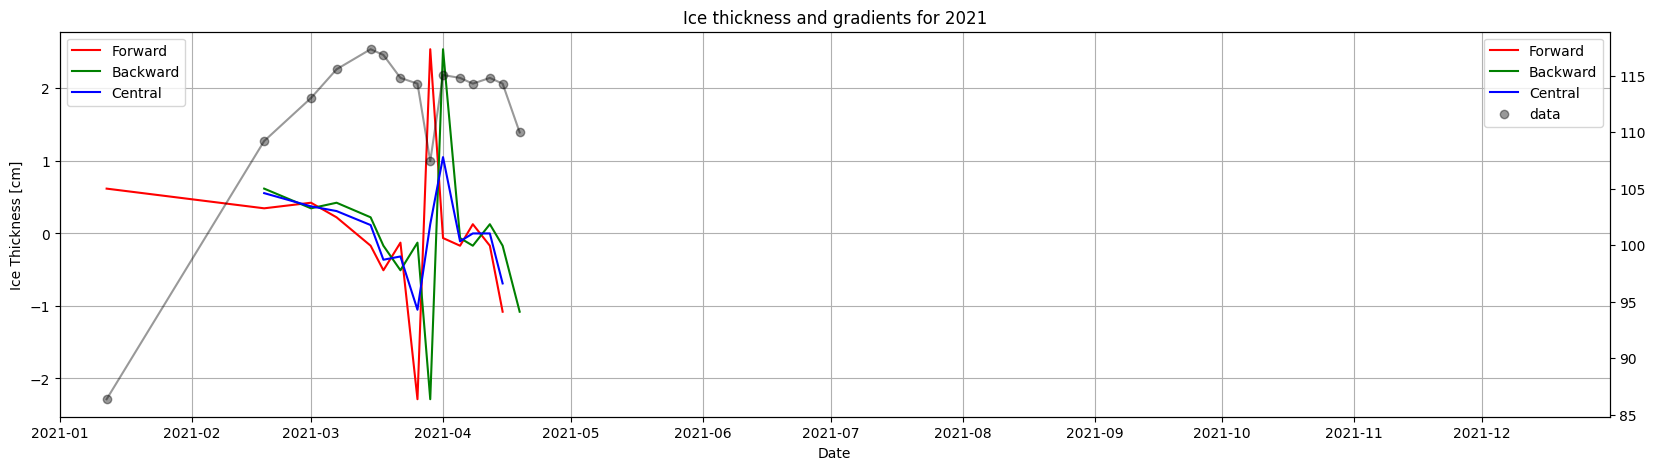

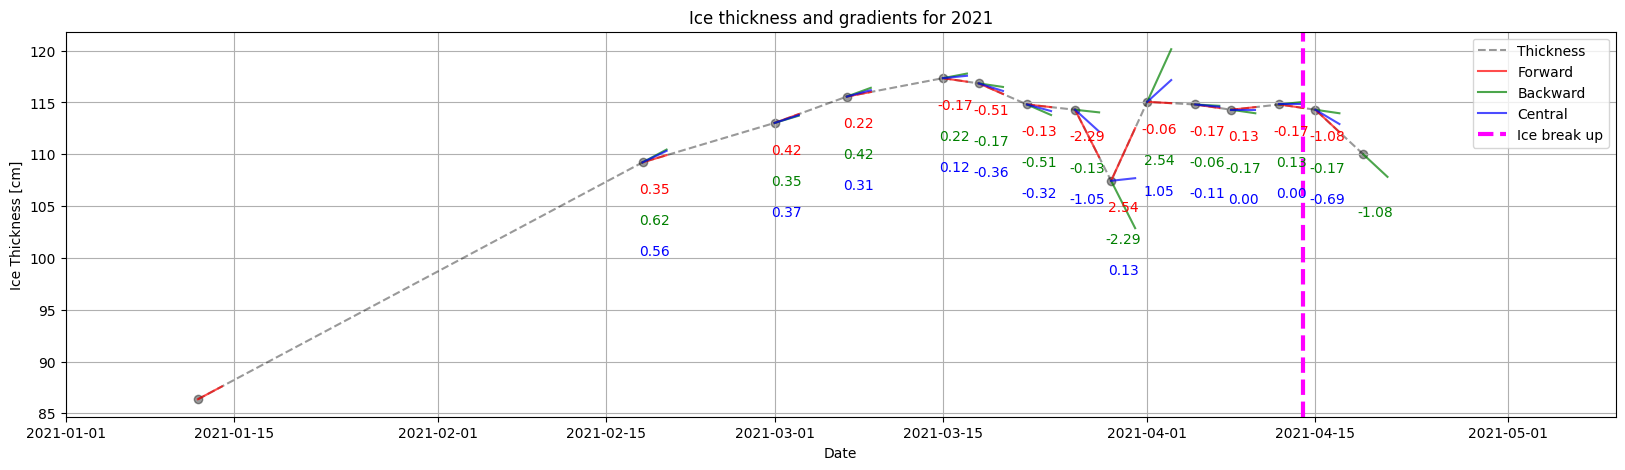

In [6]:

Ice_thickness=Data['IceThickness [cm]']
Ice_thickness=Ice_thickness.dropna(inplace=False)
result = Ice_thickness.groupby(Ice_thickness.index.year,group_keys=True).apply(lambda x: ice.finite_differences(x)).reset_index(level=0, drop=True)


ice.plot_gradients_and_timeseries(result, 
                             Ice_thickness,
                            2021,
                            Title='Ice thickness and gradients for 2021',
                            ylabel='Ice Thickness [cm]')

ice.plot_gradients_and_timeseries(result,
                            Ice_thickness,
                            year=2021,
                            plot_gradient_as_slope=True,
                            xlim=['01/01', '05/10'],
                            Title='Ice thickness and gradients for 2021',
                            ylabel='Ice Thickness [cm]', 
                            vline={'Ice break up': break_up_dates[break_up_dates.year == 2019].strftime('%m/%d')[0]})


## Discharge

>  fix plotting function, so than  when selecting an xlim, the function only compute the data in that range, right now it computes all the data and then restricts the plot which is slow 

<class 'str'>


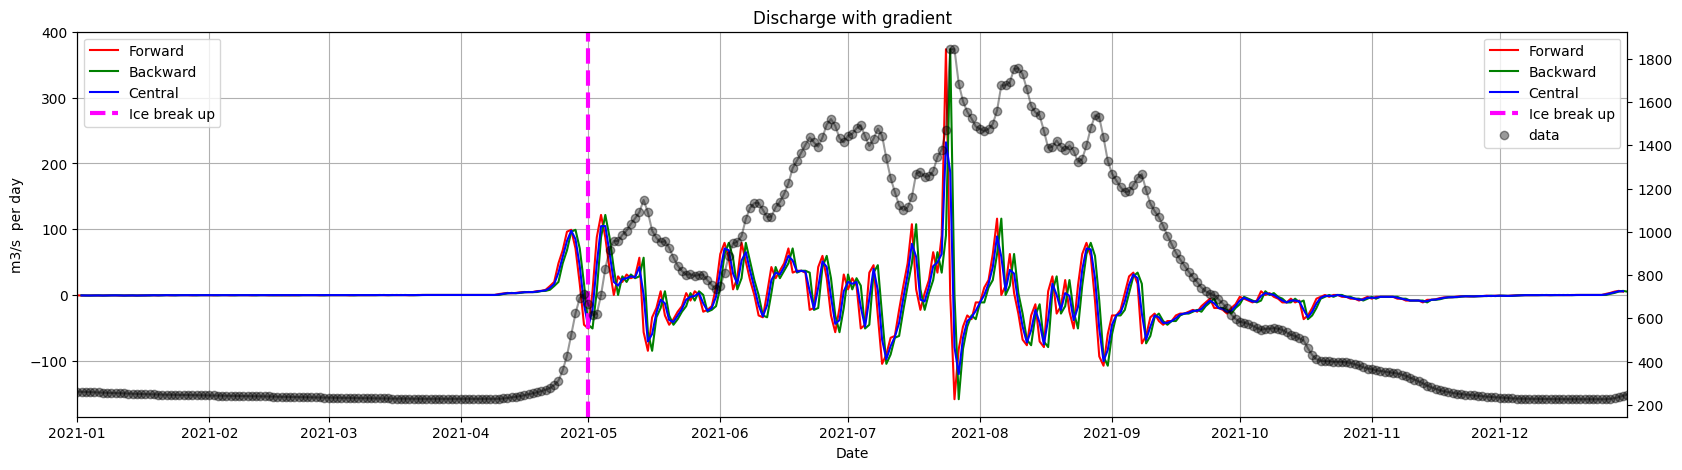

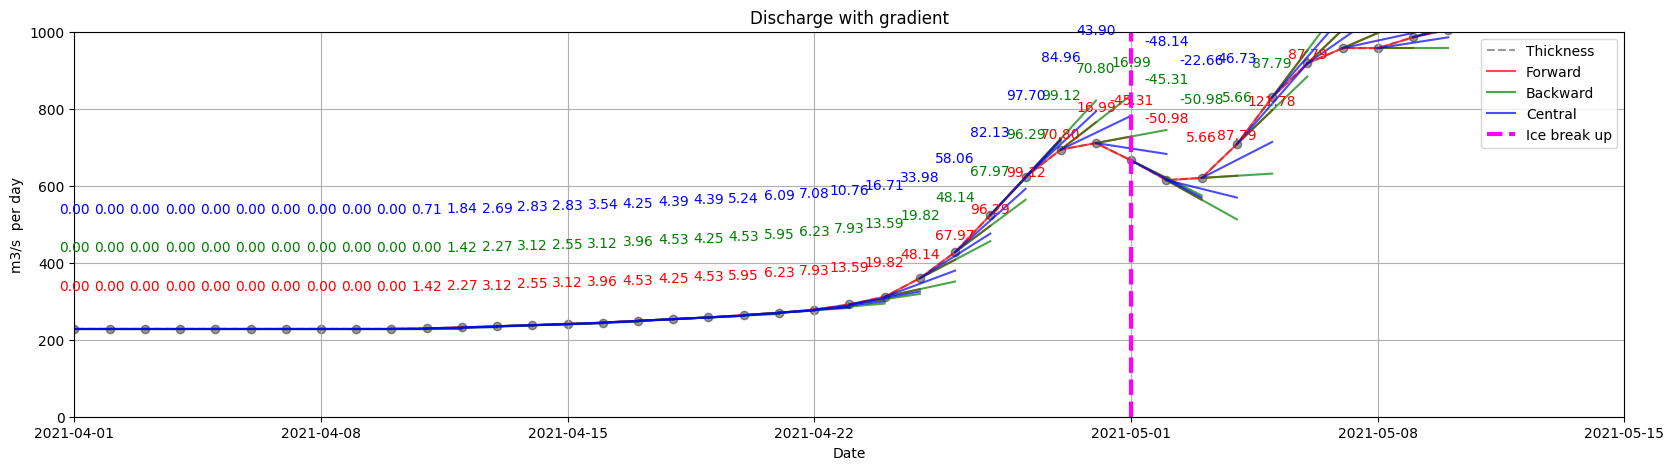

In [7]:
print(type(break_up_dates[break_up_dates.year == 2019].strftime('%m/%d')[0]))
Discharge=Data['Nenana: Mean Discharge [m3/s]']
Discharge=Discharge.dropna(inplace=False) # drop the missing values
result_2 = Discharge.groupby(Discharge.index.year,group_keys=True).apply(lambda x: ice.finite_differences(x))
result_2 = result_2.reset_index(level=0, drop=True)

ice.plot_gradients_and_timeseries(result_2,
                            Discharge,
                            2021,
                            Title='Discharge with gradient',
                            ylabel='m3/s  per day',
                            vline={'Ice break up': break_up_dates[break_up_dates.year == 2021].strftime('%m/%d')[0]})

ice.plot_gradients_and_timeseries(result_2,
                            Discharge,
                            2021,
                            plot_gradient_as_slope=True,
                            xlim=['04/01', '05/15'],
                            Title='Discharge with gradient',
                            ylabel='m3/s  per day',
                            ylim=[0, 1000],
                            annotation_offsets={'forward': 100, 'backward': 200, 'central': 300},
                            vline={'Ice break up': break_up_dates[break_up_dates.year == 2021].strftime('%m/%d')[0]})
#


## Gage Height


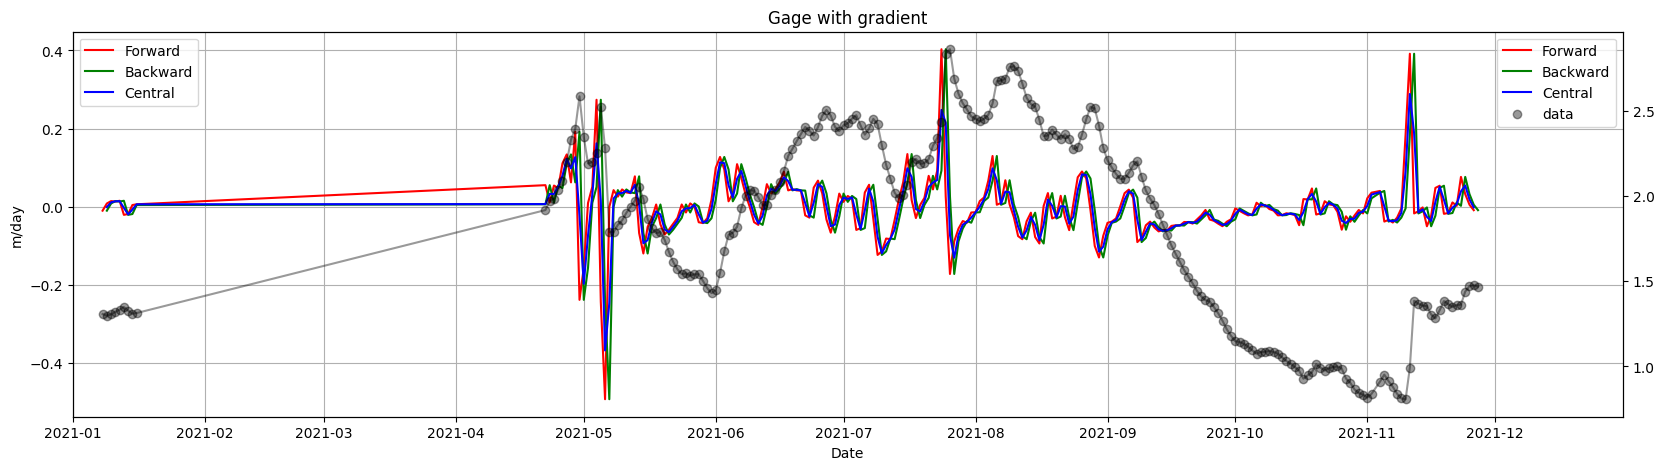

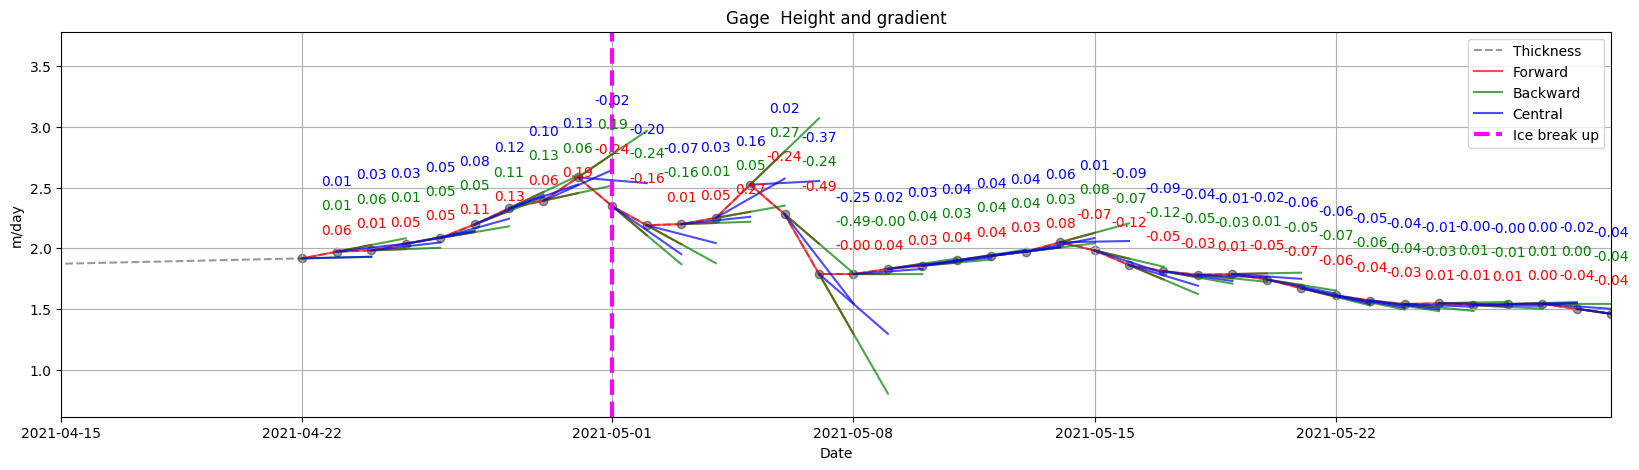

In [8]:
Gage=Data['Nenana: Gage Height [m]']
Gage=Gage.dropna(inplace=False) # drop the missing values
result_3 = Gage.groupby(Gage.index.year,group_keys=True).apply(lambda x: ice.finite_differences(x))
result_3 = result_3.reset_index(level=0, drop=True)

ice.plot_gradients_and_timeseries(result_3,
                            Gage,
                            2021,
                            Title='Gage with gradient'
                            ,ylabel='m/day')

ice.plot_gradients_and_timeseries(result_3,
                            Gage,
                            2021,
                            plot_gradient_as_slope=True,
                            xlim=['04/15', '05/30'],
                            annotation_offsets={'forward': 0.2, 'backward': 0.4, 'central': 0.6},
                            ylabel='m/day',Title='Gage  Height and gradient',
                            vline={'Ice break up': break_up_dates[break_up_dates.year == 2021].strftime('%m/%d')[0]})